# Supply Chain Logistics Problem Dataset

## Problem statement

In modern supply chain logistics, carbon emissions generated from transportation and storage activities contribute significantly to environmental degradation. With increasing global pressure to reduce carbon footprints, logistics companies must identify actionable strategies to minimize emissions without compromising efficiency or cost-effectiveness.

This project aims to develop a deep learning model that accurately predicts carbon emissions based on key operational features such as transportation distance, cargo weight, warehouse capacity, and storage cost. By leveraging historical logistics data and integrating predictive analytics, the model enables stakeholders to estimate the environmental impact of different logistics decisions.

Additionally, the project provides a route suggestion mechanism that estimates emissions for new shipment scenarios, supporting more sustainable planning. The ultimate goal is to optimize logistics operations in a way that balances cost, efficiency, and environmental responsibility.

Dataset is divided into 7 tables, one table for all orders that needs to be assigned a route – OrderList table, and 6 additional files specifying the problem and restrictions. For instance, the FreightRates table describes all available couriers, the weight gaps for each individual lane and rates associated. The PlantPorts table describes the allowed links between the warehouses and shipping ports in real world. Furthermore, the ProductsPerPlant table lists all supported warehouse-product combinations. The VmiCustomers lists all special cases, where warehouse is only allowed to support specific customer, while any other non-listed warehouse can supply any customer. Moreover, the WhCapacities lists warehouse capacities measured in number of orders per day and the WhCosts specifies the cost associated in storing the products in given warehouse measured in dollars per unit.



Order ID is ID of the order made by the customer, product ID is the specific product ID customer ordered.



"tpt_day_cnt" in the FrieghtRates table means transportation day count, i.e. estimated shipping time.



WhCapacities correspond to the number of orders. For example, let's say Customer 1 requests 10 units of X, Customer 2 requests 20 units of Y. The total number of orders is 2, thus total capacity in "whCapacity" is 2.



WhCapacities table is the maximum number of orders that can be processed per each plant, it is not dependant on specific products.



The OrderList contains historical records of how the orders were routed and demand satisfied. The whCapacities and rest of the tables are the current state constraints of the network. Thus, we can calculate the costs of historical network and also optimize for the new constraints.



In order to build Linear Programming (LP) model, you would take the following from the OrderList: the product ID that needs to be shipped, the destination port, unit quantity (for cost) and unit weight (for weight constraints). And then use the limits of those constraints from other tables.



Questions: There is a Carrier V44_3 in OrderList table, but it is missing in the FreightRates table? V44_3 is a carrier that was historically used for supplying given demand, but since it has been discontinued and therefore do not appear in the Freight Rates List. Also, all of the V44_3 instances are CRF - i.e. customer arranges their own shipping and hence cost is not calculated either way.

## Importing required libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## Loading and preprocess the data

In [4]:
order_df = pd.read_csv('OrderList.csv')
freight_df = pd.read_csv('FreightRates.csv')
plant_ports_df = pd.read_csv('PlantPorts.csv')
products_plant_df = pd.read_csv('ProductsPerPlant.csv')
vmi_customers_df = pd.read_csv('VmiCustomers.csv')
wh_capacity_df = pd.read_csv('WhCapacities.csv')
wh_cost_df = pd.read_csv('WhCosts.csv')

In [34]:
print("OrderList:", order_df.shape)
print("FreightRates:", freight_df.shape)
print("PlantPorts:", plant_ports_df.shape)
print("ProductsPerPlant:", products_plant_df.shape)
print("VmiCustomers:", vmi_customers_df.shape)
print("WhCapacities:", wh_capacity_df.shape)
print("WhCosts:", wh_cost_df.shape)

OrderList: (9215, 14)
FreightRates: (1540, 11)
PlantPorts: (22, 14)
ProductsPerPlant: (2036, 2)
VmiCustomers: (14, 2)
WhCapacities: (19, 2)
WhCosts: (20, 2)


In [8]:
order_df.head()

,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,Plant Code,Destination Port,Unit quantity,Weight
0,1447296447,5/26/2013,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30
1,1447158015,5/26/2013,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94
2,1447138899,5/26/2013,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20
3,1447363528,5/26/2013,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.16
4,1447363981,5/26/2013,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.34


In [48]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order ID              9215 non-null   int64  
 1   Order Date            9215 non-null   object 
 2   Origin Port           9215 non-null   object 
 3   Carrier               9215 non-null   object 
 4   TPT                   9215 non-null   int64  
 5   Service Level         9215 non-null   object 
 6   Ship ahead day count  9215 non-null   int64  
 7   Ship Late Day count   9215 non-null   int64  
 8   Customer              9215 non-null   object 
 9   Product ID            9215 non-null   int64  
 10  Plant Code            9215 non-null   object 
 11  Destination Port      9215 non-null   object 
 12  Unit quantity         9215 non-null   int64  
 13  Weight                9215 non-null   float64
dtypes: float64(1), int64(6), object(7)
memory usage: 1008.0+ KB


In [50]:
order_df.Carrier.value_counts(normalize=True)

,proportion
Carrier,
V444_0,0.679761
V444_1,0.227564
V44_3,0.092675


In [9]:
freight_df.head()

,Carrier,Origin Port,Destination Port,minm_wgh_qty,max_wgh_qty,svc_cd,minimum cost,rate,mode_dsc,tpt_day_cnt,Carrier type
0,V444_6,PORT08,PORT09,250.0,499.99,DTD,$43.23,$0.71,AIR,2,V88888888_0
1,V444_6,PORT08,PORT09,65.0,69.99,DTD,$43.23,$0.75,AIR,2,V88888888_0
2,V444_6,PORT08,PORT09,60.0,64.99,DTD,$43.23,$0.79,AIR,2,V88888888_0
3,V444_6,PORT08,PORT09,50.0,54.99,DTD,$43.23,$0.83,AIR,2,V88888888_0
4,V444_6,PORT08,PORT09,35.0,39.99,DTD,$43.23,$1.06,AIR,2,V88888888_0


In [10]:
wh_capacity_df.head()

,Plant Code,Capacity
0,PLANT15,11
1,PLANT17,8
2,PLANT18,111
3,PLANT05,385
4,PLANT02,138


In [11]:
wh_cost_df.head()

,Plant Code,StorageCost
0,PLANT15,1.42
1,PLANT17,0.43
2,PLANT18,2.04
3,PLANT05,0.49
4,PLANT02,0.48


In [13]:
wh_capacity_df = wh_capacity_df.rename(columns={'Plant ID': 'Plant Code', 'Daily Capacity ': 'Capacity'})
wh_cost_df = wh_cost_df.rename(columns={'WH': 'Plant Code', 'Cost/unit': 'StorageCost'})
freight_df = freight_df.rename(columns={'orig_port_cd': 'Origin Port', 'dest_port_cd': 'Destination Port'})

Merging the columns

In [14]:
merged_df = order_df.merge(wh_capacity_df, on='Plant Code', how='left')
merged_df = merged_df.merge(wh_cost_df, on='Plant Code', how='left')
merged_df = merged_df.merge(freight_df, on=['Origin Port', 'Destination Port', 'Carrier'], how='left')

In [15]:
print("Missing values in merged_df:")
print(merged_df.isnull().sum())

Missing values in merged_df:
Order ID                  0
Order Date                0
Origin Port               0
Carrier                   0
TPT                       0
Service Level             0
Ship ahead day count      0
Ship Late Day count       0
Customer                  0
Product ID                0
Plant Code                0
Destination Port          0
Unit quantity             0
Weight                    0
Capacity                  0
StorageCost               0
minm_wgh_qty            854
max_wgh_qty             854
svc_cd                  854
minimum cost            854
rate                    854
mode_dsc                854
tpt_day_cnt             854
Carrier type            854
dtype: int64


In [22]:
np.random.seed(42)
merged_df['Distance'] = np.random.uniform(100, 1000, size=len(merged_df))
merged_df['CargoWeight'] = np.random.uniform(1, 20, size=len(merged_df))

# Simulate emission factor (kg CO2 per ton-km)
emission_factor = 0.2
merged_df['CarbonEmission'] = merged_df['Distance'] * merged_df['CargoWeight'] * emission_factor

## Exploratory Data Analysis

In [24]:
print("\nBasic Statistics:")
print(merged_df[['Distance', 'CargoWeight', 'CarbonEmission', 'Capacity', 'StorageCost']].describe())


Basic Statistics:
            Distance    CargoWeight  CarbonEmission       Capacity  \
count  209402.000000  209402.000000   209402.000000  209402.000000   
mean      550.125956      10.504770     1155.981781     965.647969   
std       259.719898       5.485309      862.975381     191.291144   
min       100.004301       1.000042       20.837336      11.000000   
25%       324.717105       5.759495      451.542447    1013.000000   
50%       550.746239      10.501281      932.901083    1013.000000   
75%       774.848773      15.253293     1688.080384    1013.000000   
max       999.992838      19.999898     3984.867666    1013.000000   

         StorageCost  
count  209402.000000  
mean        0.530777  
std         0.065652  
min         0.430000  
25%         0.520000  
50%         0.520000  
75%         0.520000  
max         1.920000  


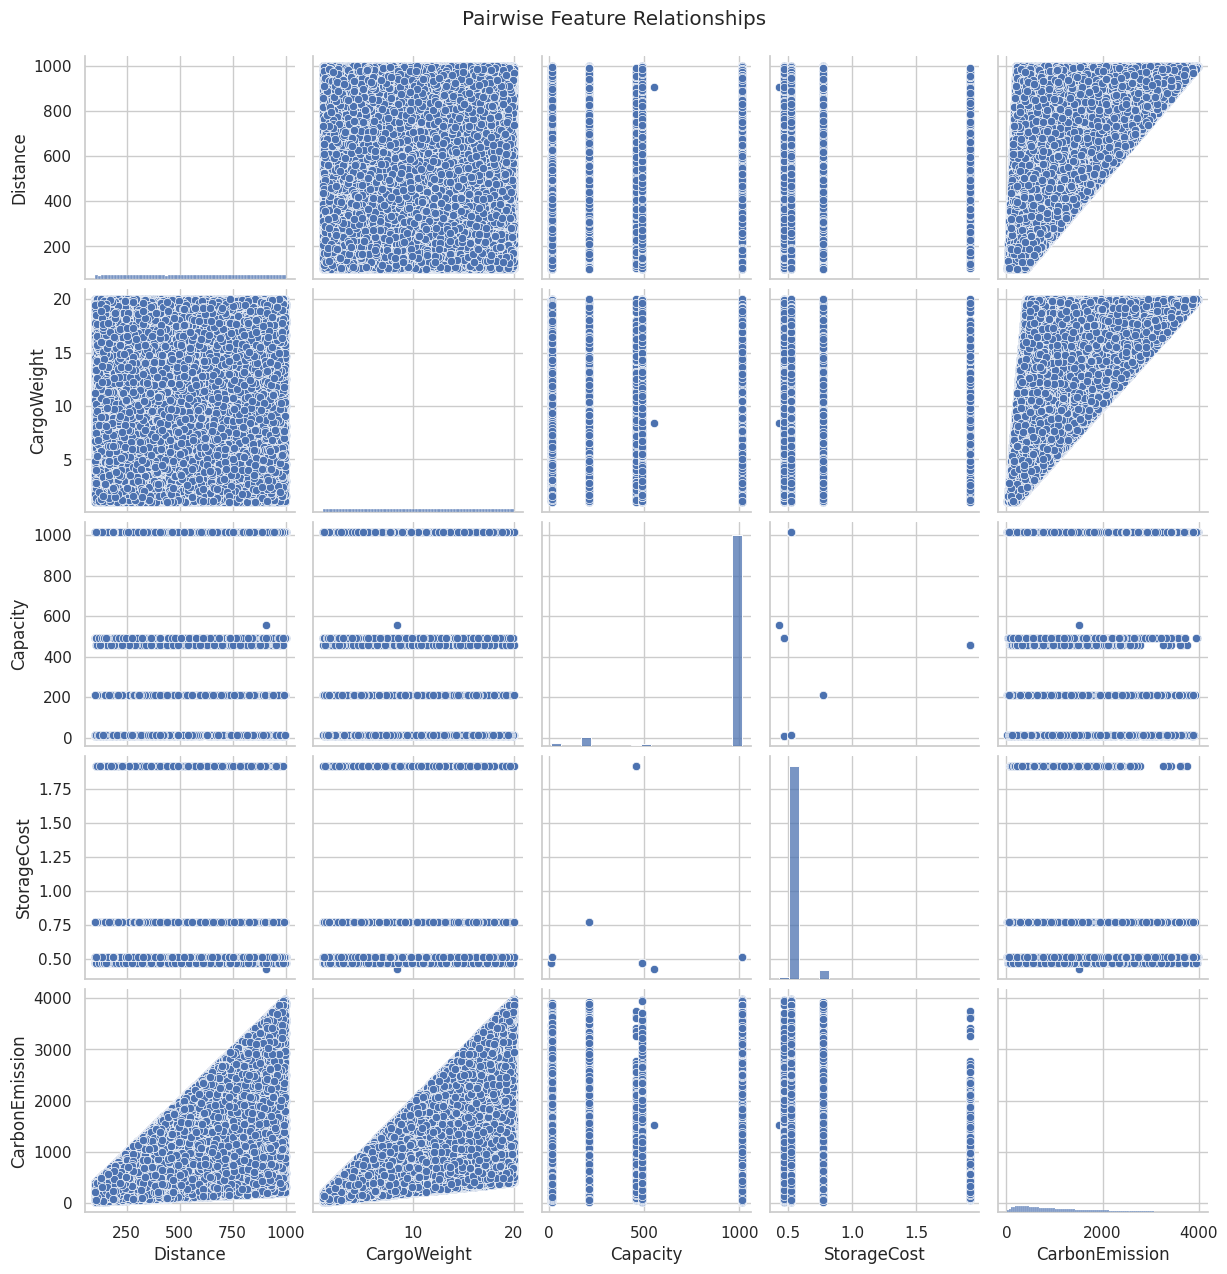

In [33]:
sns.pairplot(merged_df[['Distance', 'CargoWeight', 'Capacity', 'StorageCost', 'CarbonEmission']])
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

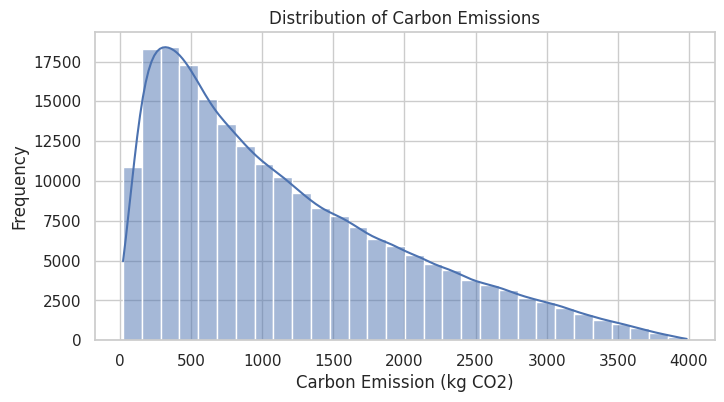

In [32]:
plt.figure(figsize=(8, 4))
sns.histplot(merged_df['CarbonEmission'], kde=True, bins=30)
plt.title("Distribution of Carbon Emissions")
plt.xlabel("Carbon Emission (kg CO2)")
plt.ylabel("Frequency")
plt.show()

Majority of shipments result in moderate emissions. A few large shipments are responsible for high emissions — which may be targets for optimization.

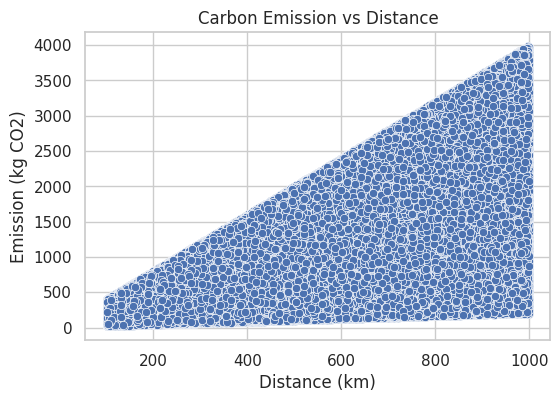

In [31]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Distance', y='CarbonEmission', data=merged_df)
plt.title("Carbon Emission vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Emission (kg CO2)")
plt.show()

Reducing distance through optimal routing has a direct and significant effect on emission reduction.

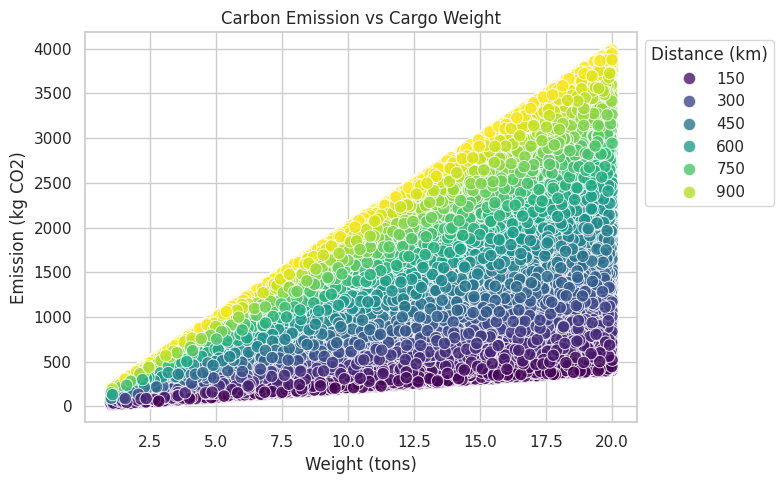

In [53]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='CargoWeight', y='CarbonEmission', data=merged_df, palette='viridis', hue='Distance', alpha=0.8, s=80)
plt.title("Carbon Emission vs Cargo Weight")
plt.xlabel("Weight (tons)")
plt.ylabel("Emission (kg CO2)")
plt.legend(title="Distance (km)", loc='upper left', bbox_to_anchor=(1, 1)),
plt.tight_layout()
plt.show()

Splitting large cargo into multiple smaller shipments (where feasible) or using more efficient carriers for heavy cargo could help reduce emissions

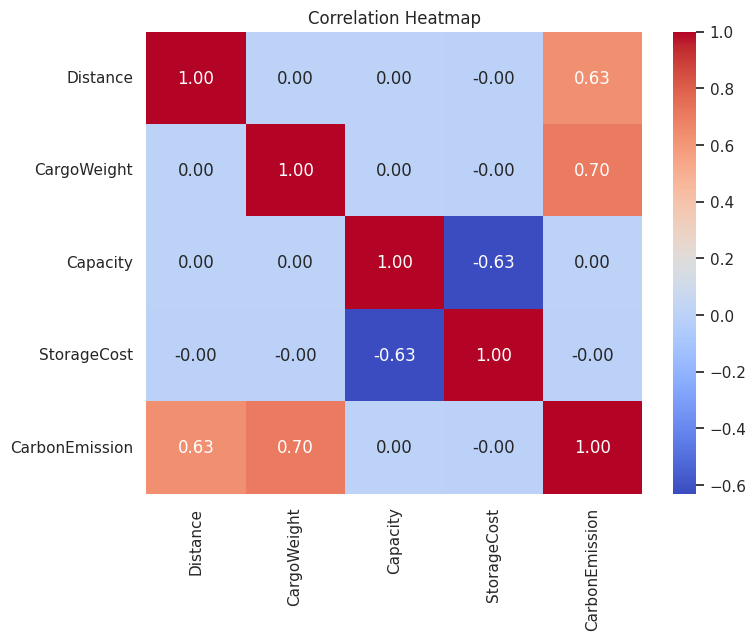

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    merged_df[['Distance', 'CargoWeight', 'Capacity', 'StorageCost', 'CarbonEmission']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Heatmap")
plt.show()

The amount of carbon emissions is mainly influenced by how far the shipment travels (distance) and how heavy the cargo is (weight). The farther and heavier the shipment, the more emissions it produces.

In [35]:
np.random.seed(42)
merged_df['Distance'] = np.random.uniform(100, 1000, size=len(merged_df))
merged_df['CargoWeight'] = np.random.uniform(1, 20, size=len(merged_df))

In [36]:
emission_factor = 0.2
merged_df['CarbonEmission'] = merged_df['Distance'] * merged_df['CargoWeight'] * emission_factor

## Feature Selection and Data preparation

In [37]:
features = merged_df[['Distance', 'CargoWeight', 'Capacity', 'StorageCost']].fillna(0)
labels = merged_df['CarbonEmission']

Extract relevant features and target label for the model.

In [38]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Normalize feature values for faster convergence and improved performance.

In [39]:
X_temp, X_test, y_temp, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

Split dataset into training, validation, and test sets.

In [40]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

Convert NumPy arrays to PyTorch tensors for training.

In [41]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Creating the batches for efficient training with `DataLoader`.

## Model building

In [42]:
class EmissionPredictor(nn.Module):
    def __init__(self):
        super(EmissionPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

Defining the feedforward neural network with 3 hidden layers.ie(256 , 128, 64)

Applying ReLU activation function and Dropout layer to reduce the overfitting

In [43]:
model = EmissionPredictor()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Setting up loss function, optimizer and learning rate.

In [44]:
epochs = 20
best_val_loss = float('inf')
patience = 10
wait = 0

Initializing early stopping parameters

In [45]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor).item()
        scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered")
            break

Epoch [1/20], Train Loss: 49626.6856, Val Loss: 529.0422
Epoch [2/20], Train Loss: 7208.7018, Val Loss: 508.7712
Epoch [3/20], Train Loss: 6270.1746, Val Loss: 140.2201
Epoch [4/20], Train Loss: 5770.5321, Val Loss: 174.8714
Epoch [5/20], Train Loss: 5470.7997, Val Loss: 275.8182
Epoch [6/20], Train Loss: 5138.2436, Val Loss: 164.0208
Epoch [7/20], Train Loss: 4885.4412, Val Loss: 640.5975
Epoch [8/20], Train Loss: 4593.8018, Val Loss: 315.7112
Epoch [9/20], Train Loss: 4311.3122, Val Loss: 646.2849
Epoch [10/20], Train Loss: 3956.9476, Val Loss: 306.0424
Epoch [11/20], Train Loss: 3802.6389, Val Loss: 917.0447
Epoch [12/20], Train Loss: 3711.8663, Val Loss: 415.9999
Epoch [13/20], Train Loss: 3525.8892, Val Loss: 1065.0895
Early stopping triggered


Training the model over multiple epochs and tracking the validation loss with early stopping

In [46]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    true = y_test_tensor.numpy()
    mae = mean_absolute_error(true, predictions)
    rmse = np.sqrt(mean_squared_error(true, predictions))
    mape = mean_absolute_percentage_error(true, predictions)

print(f"MAE: {mae:.2f} kg CO2")
print(f"RMSE: {rmse:.2f} kg CO2")
print(f"MAPE: {mape*100:.2f}%")

MAE: 24.63 kg CO2
RMSE: 32.65 kg CO2
MAPE: 4.71%


Evaluating the model using MAE, RMSE & MAPE.

In [47]:
def suggest_route(distance, weight, capacity, cost):
    x = scaler.transform([[distance, weight, capacity, cost]])
    x_tensor = torch.tensor(x, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        emission = model(x_tensor).item()
    return emission

example_emission = suggest_route(300, 10, 500, 2.5)
print(f"Suggested route emission: {example_emission:.2f} kg CO2")

Suggested route emission: 703.25 kg CO2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Given with new inputs( distance, cargo weights, cost, etc..) the model predicts the estimated carbon emmission for that route.